In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mrcfile
import os
import logging
%load_ext autoreload
%autoreload 2

In [21]:
from aspire.operators import IdentityFilter, RadialCTFFilter
from aspire.source.simulation import Simulation
from aspire.source.relion import RelionSource
from aspire.volume import Volume
from aspire.utils.coor_trans import uniform_random_angles
from aspire.image import Image
from aspire.utils.matrix import anorm
from aspire.utils.types import utest_tolerance
from aspire.utils.random import Random

In [8]:
def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    if randomise:
        np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

Two conformations
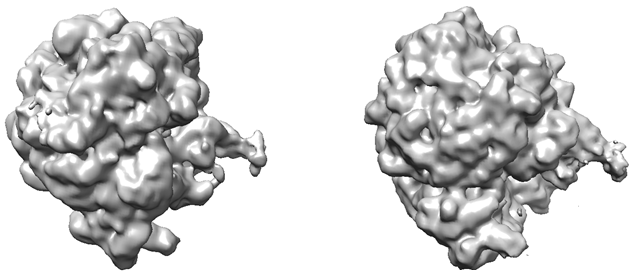

In [9]:
logger = logging.getLogger('aspire')
DATA_DIR = 'dataset/'

In [10]:
# Set the sizes of images
img_size = 130
# Set the total number of images generated from the 3D map
num_imgs = 5000
duplicate = 100

# Set the number of 3D maps
num_maps = 1

# Set the signal-noise ratio
sn_ratio = 0.1

# Specify the CTF parameters
pixel_size = 2.82                # Pixel size of the images (in angstroms).
voltage = 200                    # Voltage (in KV)
defocus_min = 1.5e4              # Minimum defocus value (in angstroms).
defocus_max = 2.0e4              # Maximum defocus value (in angstroms).
defocus_ct = 50                 # Number of defocus groups.
Cs = 2.0                         # Spherical aberration
alpha = 0.1                      # Amplitude contrast

In [11]:
infile = mrcfile.open(os.path.join(DATA_DIR, '70S_Conform1.mrc'))
vols = infile.data

In [13]:
v = Volume(vols)

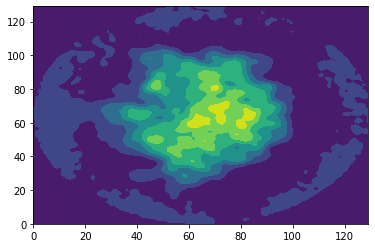

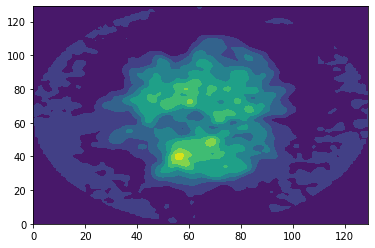

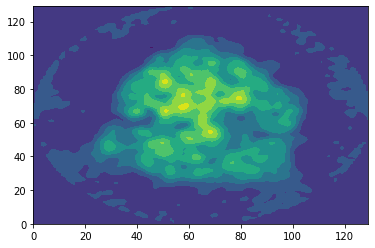

In [18]:
for axis in range(3):
    plt.contourf(np.arange(img_size),np.arange(img_size), np.sum(v[0], axis=axis))
    plt.show()

In [20]:
# a total of 50 distinct 2D imageswere generated by projecting the 3D structure of 70S ribosome in random
# orientations. 5,000 images were generated from these 50 projections by making 100 copies for each projection. 
# For each projection, the 100 copies from i = 1 to i = 100 are uniformly rotated with 3:6i degree.

# https://en.wikipedia.org/wiki/Euler_angles#Definition_by_intrinsic_rotations   zyz convention

rot = np.repeat(np.random.random(int(num_imgs/duplicate)) * 2 * np.pi, duplicate)          #alpha
tilt = np.repeat(np.arccos(2 * np.random.random(int(num_imgs/duplicate)) - 1), duplicate)  #beta
psi = np.tile(np.linspace(0, 2*np.pi, duplicate, endpoint=False), int(num_imgs/duplicate)) #gamma (in-plane rotation)
my_angles = np.column_stack((rot, tilt, psi))

In [23]:
# Create filters
filters = [RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
           for d in np.linspace(defocus_min, defocus_max, defocus_ct)]

In [26]:
sim = Simulation(
    L = img_size,
    n=num_imgs,
    vols=v,
    C=num_maps,
    unique_filters=filters,
    angles = my_angles, #default is uniform_random_angle https://github.com/ComputationalCryoEM/ASPIRE-Python/blob/4fdf77dc35fc14adc582e1750dea4f1f84d0fda7/src/aspire/utils/coor_trans.py#L126
    offsets=0.0, #shift, default is random L/16
    amplitudes=1.0  #contrast, default is random 2/3~3/2
)

In [27]:
sim._metadata

_rlnClassNumber  _rlnAngleRot  _rlnAngleTilt  _rlnAnglePsi  _rlnVoltage  \
0                   1    322.384790     126.919202           0.0        200.0   
1                   1    322.384790     126.919202           3.6        200.0   
2                   1    322.384790     126.919202           7.2        200.0   
3                   1    322.384790     126.919202          10.8        200.0   
4                   1    322.384790     126.919202          14.4        200.0   
...               ...           ...            ...           ...          ...   
4995                1     44.478121      94.166027         342.0        200.0   
4996                1     44.478121      94.166027         345.6        200.0   
4997                1     44.478121      94.166027         349.2        200.0   
4998                1     44.478121      94.166027         352.8        200.0   
4999                1     44.478121      94.166027         356.4        200.0   

      _rlnDefocusU  _rlnDefocusV  _rlnDefocusAngle  _rlnSphericalAberration  \
0     19081.632653  19081.632653               0.0                      2.0   
1     19591.836735  19591.836735               0.0                      2.0   
2     15612.244898  15612.244898               0.0                      2.0   
3     19591.836735  19591.836735               0.0                      2.0   
4     18163.265306  18163.265306               0.0                      2.0   
...            ...           ...               ...                      ...   
4995  16632.653061  16632.653061               0.0                      2.0   
4996  18367.346939  18367.346939               0.0                      2.0   
4997  16428.571429  16428.571429               0.0                      2.0   
4998  19693.877551  19693.877551               0.0                      2.0   
4999  16428.571429  16428.571429               0.0                      2.0   

      _rlnAmplitudeContrast  __filter_indices  _rlnOriginX  _rlnOriginY  \
0                       0.1                40          0.0          0.0   
1                       0.1                45          0.0          0.0   
2                       0.1                 6          0.0          0.0   
3                       0.1                45          0.0          0.0   
4                       0.1                31          0.0          0.0   
...                     ...               ...          ...          ...   
4995                    0.1                16          0.0          0.0   
4996                    0.1                33          0.0          0.0   
4997                    0.1                14          0.0          0.0   
4998                    0.1                46          0.0          0.0   
4999                    0.1                14          0.0          0.0   

      _rlnAmplitude  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  
...             ...  
4995            1.0  
4996            1.0  
4997            1.0  
4998            1.0  
4999            1.0  

[5000 rows x 14 columns]

In [28]:
# Generate 2D clean images from input 3D map. The following statement can be used from the sim object:
imgs_clean = sim.projections(start=0, num=num_imgs)

2021-11-03 10:33:08,127 INFO Trying NFFT backend finufft
2021-11-03 10:33:08,183 INFO NFFT backend finufft usable.
2021-11-03 10:33:08,184 INFO Trying NFFT backend cufinufft
2021-11-03 10:33:08,188 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2021-11-03 10:33:08,189 INFO Trying NFFT backend pynfft
2021-11-03 10:33:08,190 INFO NFFT backend pynfft not usable:
	No module named 'pynfft'
2021-11-03 10:33:08,190 INFO Selected NFFT backend = finufft.


c:\users\adm\anaconda3\envs\aspire_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


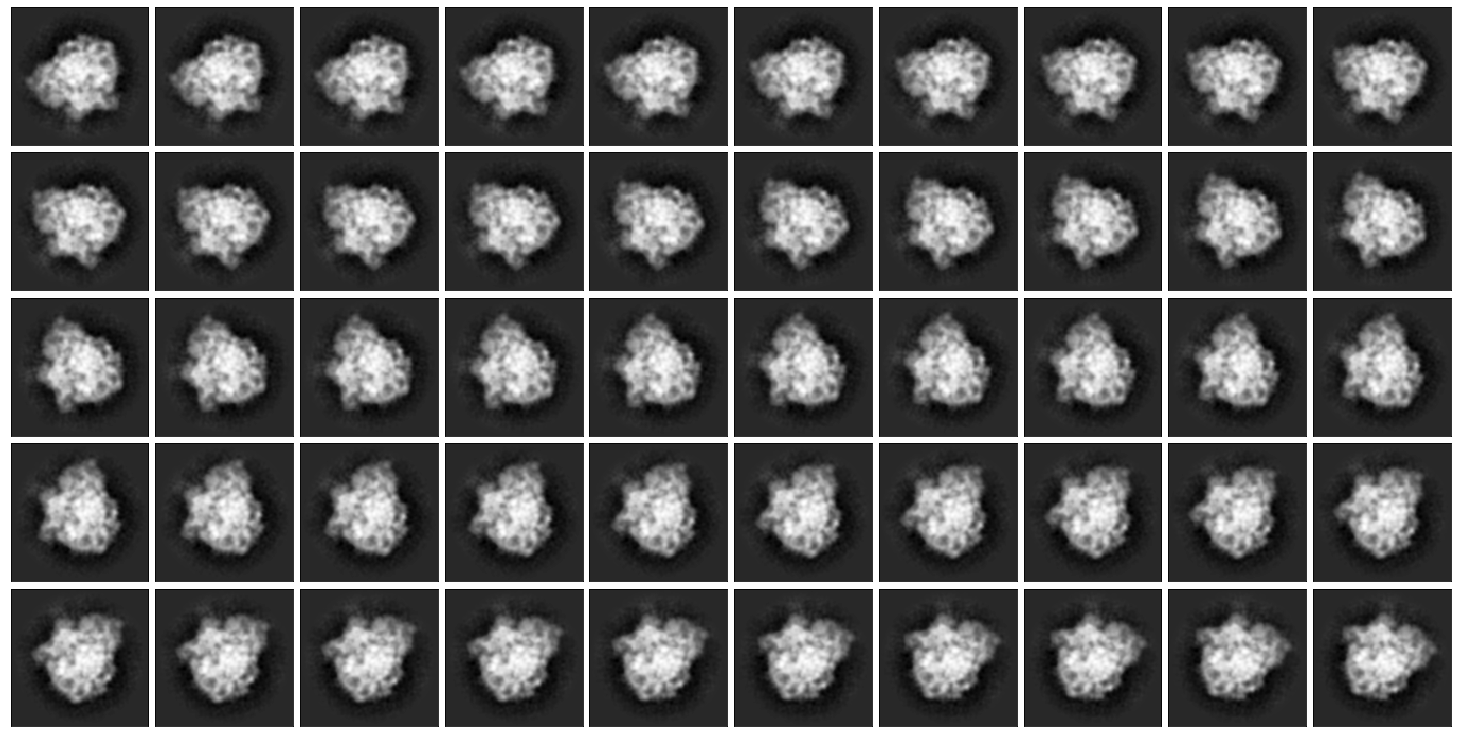

In [33]:
visualise_images(imgs_clean.asnumpy(), 50 , 10, False)

In [34]:
# Apply the CTF to the clean images.
imgs_ctf_clean = sim.eval_filters(imgs_clean)

c:\users\adm\anaconda3\envs\aspire_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


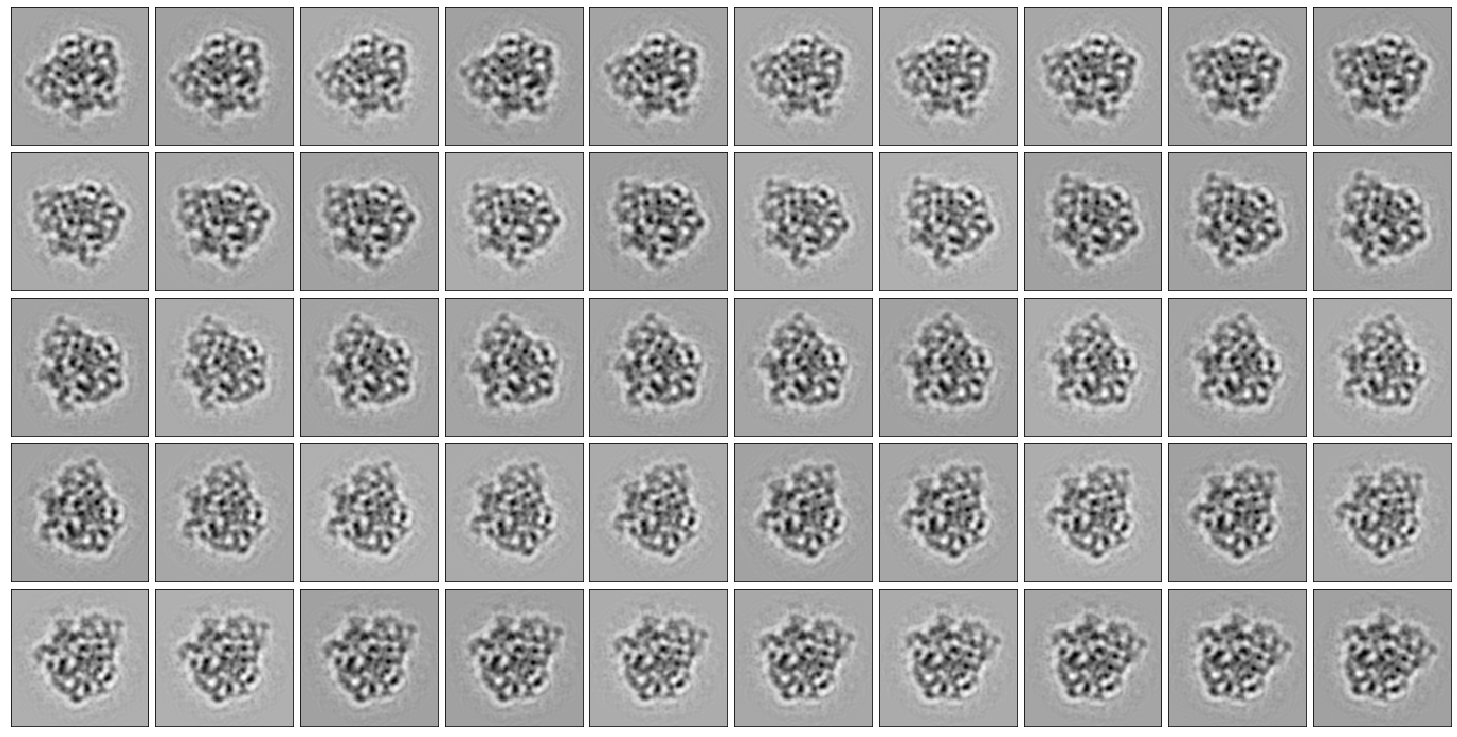

In [35]:
visualise_images(imgs_ctf_clean.asnumpy(), 50 , 10, False)

In [36]:
# imgs_ctf_clean is an Image object. Convert to numpy array for subsequent statements
imgs_ctf_clean = imgs_ctf_clean.asnumpy()

# Apply the noise at the desired singal-noise ratio to the filtered clean images
#power_clean = anorm(imgs_ctf_clean)**2/np.size(imgs_ctf_clean) # first definition in wiki
imgs_ctf_clean.var() # subtract mean, definition in ESL (https://stats.stackexchange.com/questions/31158/how-to-simulate-signal-noise-ratio)

0.0004748395

In [38]:
noise_var = imgs_ctf_clean.var()/sn_ratio
imgs_noise = imgs_ctf_clean + np.sqrt(noise_var)*np.random.randn(num_imgs, img_size, img_size)  #or you can use the noisefilter instead  https://github.com/ComputationalCryoEM/ASPIRE-Python/blob/master/tutorials/examples/cov2d_simulation.py

c:\users\adm\anaconda3\envs\aspire_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


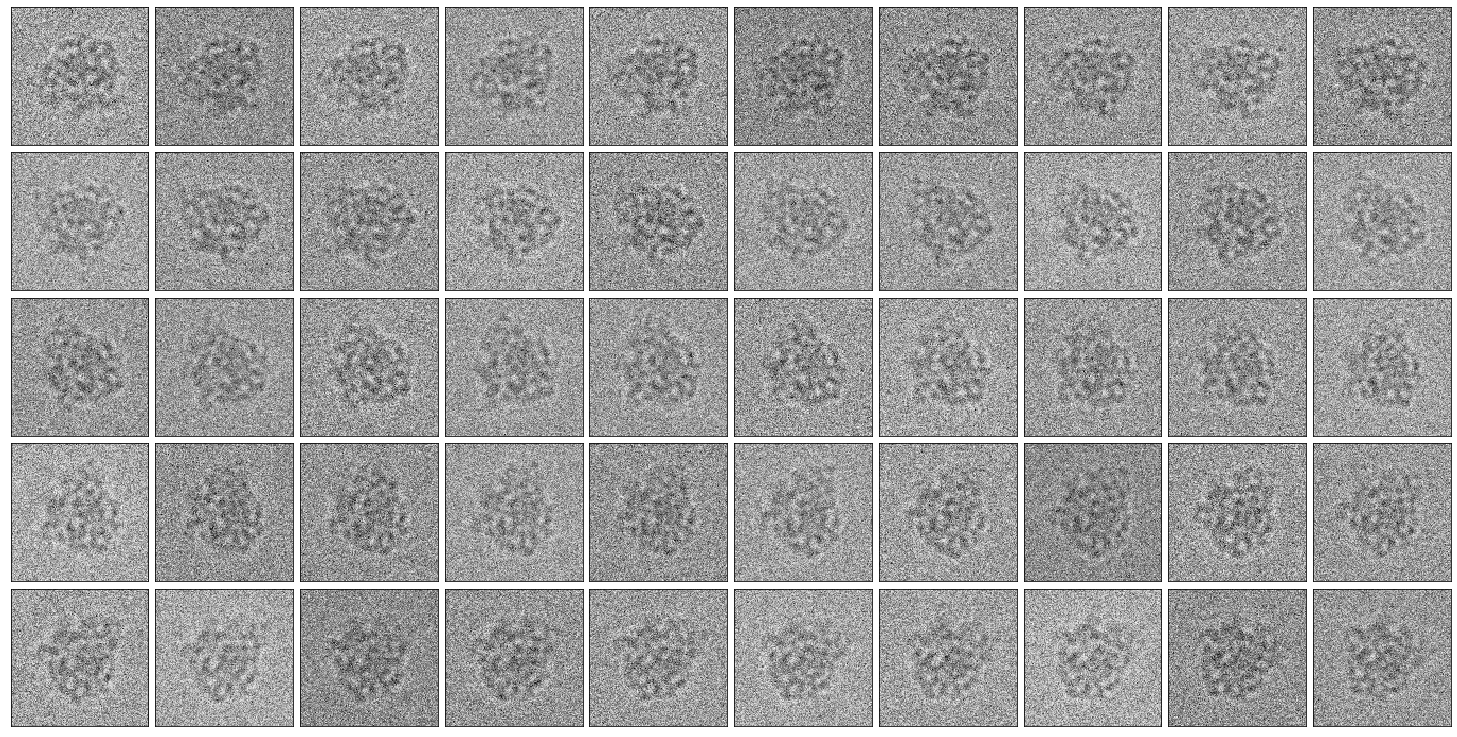

In [40]:
visualise_images(imgs_noise, 50 , 10, False)

In [43]:
sim.save("simulate.star", batch_size=num_imgs, overwrite=True)

2021-11-03 10:53:33,219 INFO save metadata into STAR file
2021-11-03 10:53:33,647 INFO save images into MRCS file
2021-11-03 10:53:33,657 INFO Saving ImageSource[0-4999] to simulate_0_4999.mrcs
2021-11-03 10:54:32,440 INFO Applying forward transformations in pipeline
2021-11-03 10:54:32,440 INFO All forward transformations applied
2021-11-03 10:54:32,441 INFO Loaded 5000 images


In [44]:
relion_src = RelionSource("simulate.star")

2021-11-03 10:55:44,572 INFO Parsing starfile at path simulate.star
2021-11-03 10:55:44,601 INFO StarFile parse complete
2021-11-03 10:55:44,602 INFO Initializing StarFile object from data
2021-11-03 10:55:44,602 INFO Created <StarFile with 1 blocks>


In [46]:
relion_src._metadata

_rlnClassNumber  _rlnAngleRot  _rlnAngleTilt  _rlnAnglePsi  _rlnVoltage  \
0                   1    322.384790     126.919202           0.0        200.0   
1                   1    322.384790     126.919202           3.6        200.0   
2                   1    322.384790     126.919202           7.2        200.0   
3                   1    322.384790     126.919202          10.8        200.0   
4                   1    322.384790     126.919202          14.4        200.0   
...               ...           ...            ...           ...          ...   
4995                1     44.478121      94.166027         342.0        200.0   
4996                1     44.478121      94.166027         345.6        200.0   
4997                1     44.478121      94.166027         349.2        200.0   
4998                1     44.478121      94.166027         352.8        200.0   
4999                1     44.478121      94.166027         356.4        200.0   

      _rlnDefocusU  _rlnDefocusV  _rlnDefocusAngle  _rlnSphericalAberration  \
0     19081.632653  19081.632653               0.0                      2.0   
1     19591.836735  19591.836735               0.0                      2.0   
2     15612.244898  15612.244898               0.0                      2.0   
3     19591.836735  19591.836735               0.0                      2.0   
4     18163.265306  18163.265306               0.0                      2.0   
...            ...           ...               ...                      ...   
4995  16632.653061  16632.653061               0.0                      2.0   
4996  18367.346939  18367.346939               0.0                      2.0   
4997  16428.571429  16428.571429               0.0                      2.0   
4998  19693.877551  19693.877551               0.0                      2.0   
4999  16428.571429  16428.571429               0.0                      2.0   

      _rlnAmplitudeContrast  _rlnOriginX  _rlnOriginY _rlnAmplitude  \
0                       0.1          0.0          0.0           1.0   
1                       0.1          0.0          0.0           1.0   
2                       0.1          0.0          0.0           1.0   
3                       0.1          0.0          0.0           1.0   
4                       0.1          0.0          0.0           1.0   
...                     ...          ...          ...           ...   
4995                    0.1          0.0          0.0           1.0   
4996                    0.1          0.0          0.0           1.0   
4997                    0.1          0.0          0.0           1.0   
4998                    0.1          0.0          0.0           1.0   
4999                    0.1          0.0          0.0           1.0   

                    _rlnImageName  __mrc_index        __mrc_filename  \
0     000001@simulate_0_4999.mrcs            1  simulate_0_4999.mrcs   
1     000002@simulate_0_4999.mrcs            2  simulate_0_4999.mrcs   
2     000003@simulate_0_4999.mrcs            3  simulate_0_4999.mrcs   
3     000004@simulate_0_4999.mrcs            4  simulate_0_4999.mrcs   
4     000005@simulate_0_4999.mrcs            5  simulate_0_4999.mrcs   
...                           ...          ...                   ...   
4995  004996@simulate_0_4999.mrcs         4996  simulate_0_4999.mrcs   
4996  004997@simulate_0_4999.mrcs         4997  simulate_0_4999.mrcs   
4997  004998@simulate_0_4999.mrcs         4998  simulate_0_4999.mrcs   
4998  004999@simulate_0_4999.mrcs         4999  simulate_0_4999.mrcs   
4999  005000@simulate_0_4999.mrcs         5000  simulate_0_4999.mrcs   

            __mrc_filepath  __filter_indices  
0     simulate_0_4999.mrcs                40  
1     simulate_0_4999.mrcs                45  
2     simulate_0_4999.mrcs                 6  
3     simulate_0_4999.mrcs                45  
4     simulate_0_4999.mrcs                31  
...                    ...               ...  
4995  simulate_0_4999.mrcs           

In [56]:
mrc = mrcfile.open('simulate_0_4999.mrcs', mode='r+') #Remember to replace this with noisy images
mrc.set_data(np.array(imgs_noise, dtype=np.float32))
mrc.close()

In [57]:
imgs = relion_src._images() 
imgs

2021-11-03 11:04:21,920 INFO Loading 5000 images from STAR file
2021-11-03 11:04:22,136 INFO Loading 5000 images complete


5000 images of size 130x130

c:\users\adm\anaconda3\envs\aspire_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


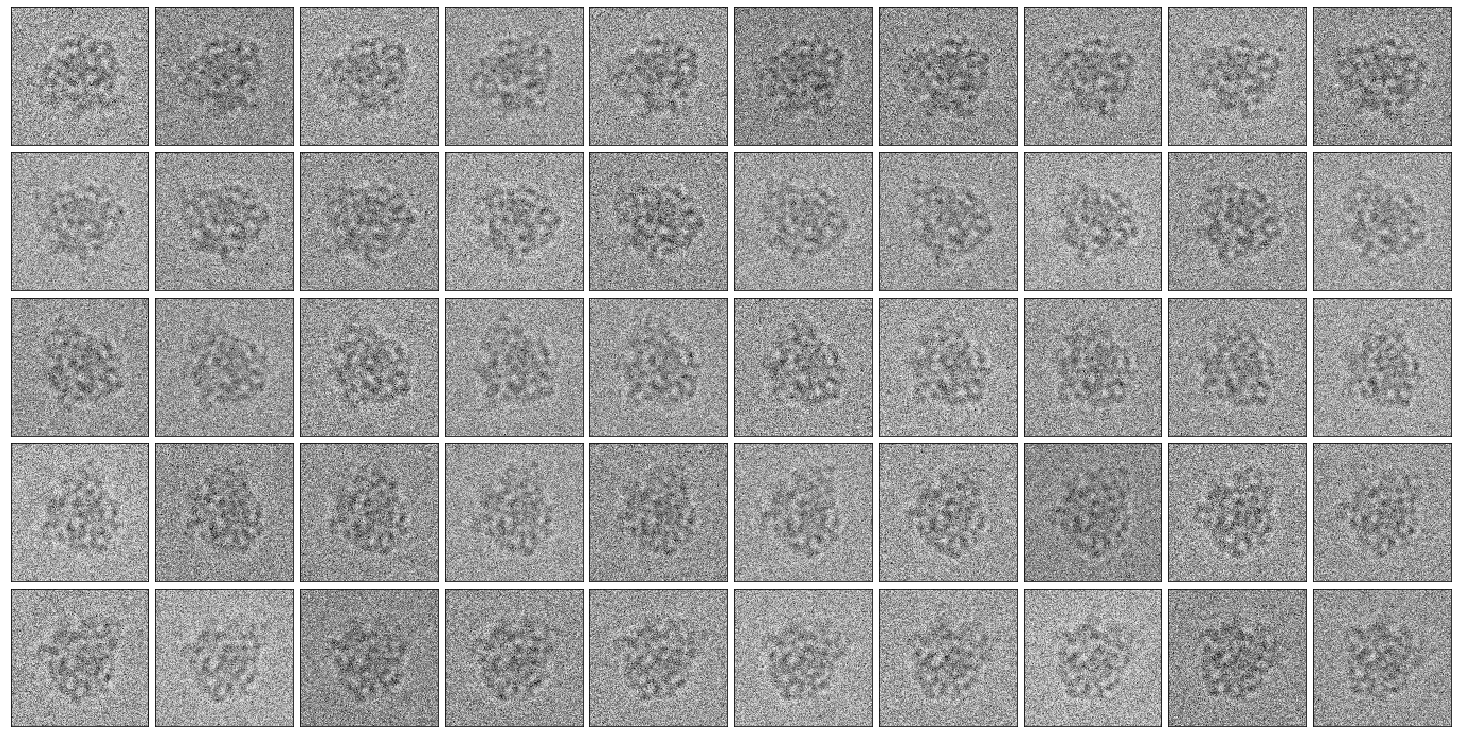

In [58]:
visualise_images(imgs.asnumpy(), 50 , 10, False)